# Computational Graph and Visual Backpropagation

We'll build a simple computational graph and visually walk through backpropagation.

We'll use a simple linear unit and a squared-error loss:

- Forward:  y = x1*w1 + x2*w2 + b
- Loss:     L = 0.5 * (y - t)^2

We'll compute:
- Forward values for each node
- Gradients flowing backward from L to every input/parameter
- A small diagram showing the forward values (black) and backward gradients (red)

In [1]:
x1, x2 = 2.0, -3.0
w1, w2 = 0.5, -1.0
b      = 0.1
t      = 1.5  

# Forward computations
y = x1*w1 + x2*w2 + b
L = 0.5 * (y - t)**2

values = {
    'x1': x1,
    'x2': x2,
    'w1': w1,
    'w2': w2,
    'b': b,
    'y': y,
    't': t,
    'L': L,
}

print('Forward values:')
for k in ['x1','x2','w1','w2','b','t','y','L']:
    print(f"  {k:>2} = {values[k]: .6f}")

# Backward (manual backprop)
dL_dy = (y - t)

# Local derivatives for y = x1*w1 + x2*w2 + b
dy_dw1, dy_dw2 = x1, x2
dy_db = 1.0
dy_dx1, dy_dx2 = w1, w2

# Chain rule to parameters and inputs
grads = {
    'dL/dy': dL_dy,
    'dL/dw1': dL_dy * dy_dw1,
    'dL/dw2': dL_dy * dy_dw2,
    'dL/db': dL_dy * dy_db,
    'dL/dx1': dL_dy * dy_dx1,
    'dL/dx2': dL_dy * dy_dx2,
}

print('\nBackward gradients:')
for k in ['dL/dy','dL/dw1','dL/dw2','dL/db','dL/dx1','dL/dx2']:
    print(f"  {k:>7} = {grads[k]: .6f}")

Forward values:
  x1 =  2.000000
  x2 = -3.000000
  w1 =  0.500000
  w2 = -1.000000
   b =  0.100000
   t =  1.500000
   y =  4.100000
   L =  3.380000

Backward gradients:
    dL/dy =  2.600000
   dL/dw1 =  5.200000
   dL/dw2 = -7.800000
    dL/db =  2.600000
   dL/dx1 =  1.300000
   dL/dx2 = -2.600000


## Chain rule (by hand)

Forward definitions:

- y = x₁·w₁ + x₂·w₂ + b
- L = 0.5·(y − t)²

Local derivatives:

- ∂L/∂y = (y − t)
- ∂y/∂w₁ = x₁,  ∂y/∂w₂ = x₂,  ∂y/∂b = 1
- ∂y/∂x₁ = w₁,  ∂y/∂x₂ = w₂

Chain rule to get gradients wrt parameters and inputs:

- ∂L/∂w₁ = ∂L/∂y · ∂y/∂w₁ = (y − t)·x₁
- ∂L/∂w₂ = (y − t)·x₂
- ∂L/∂b  = (y − t)
- ∂L/∂x₁ = (y − t)·w₁
- ∂L/∂x₂ = (y − t)·w₂

If we were to do one gradient-descent step with learning rate η:

- w₁ ← w₁ − η·∂L/∂w₁,   w₂ ← w₂ − η·∂L/∂w₂,   b ← b − η·∂L/∂b

In the next cell we'll draw the graph and overlay the forward values (black) and backward gradients (red).

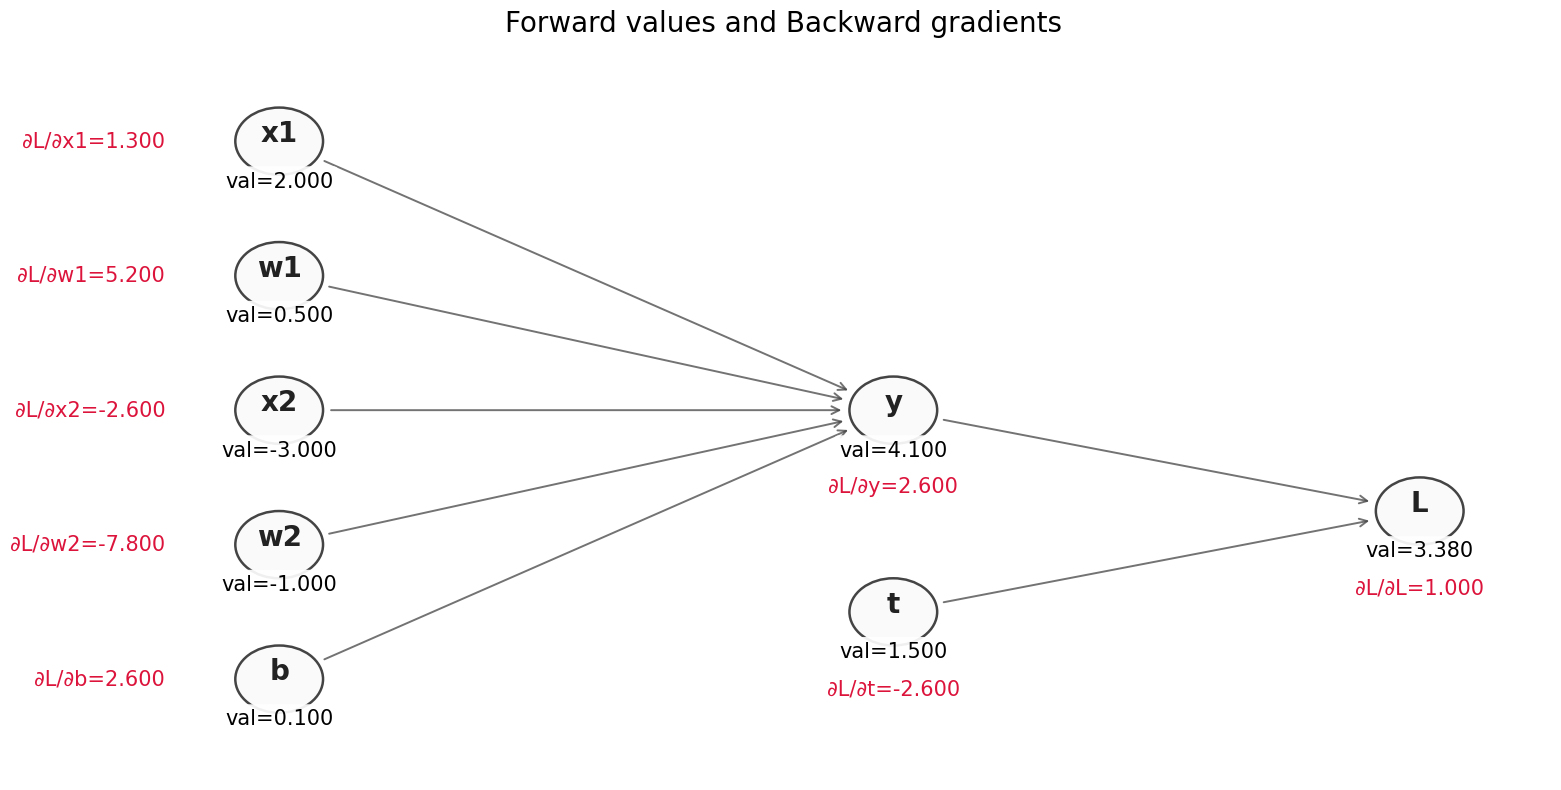

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from math import hypot

RADIUS = 0.50  

def draw_node(ax, xy, name, val=None, grad=None, grad_pos='below'):
    x, y = xy
    circle = Circle((x, y), radius=RADIUS, facecolor='#fafafa', edgecolor='#444', lw=1.8, zorder=3)
    ax.add_patch(circle)

    # Name
    ax.text(x, y+0.10, name, ha='center', va='center', fontsize=20, fontweight='bold', color='#222', zorder=4)

    # Value (inside)
    if val is not None:
        ax.text(
            x, y-0.6, f"val={val:.3f}",
            ha='center', va='center', fontsize=15, color='black', zorder=4,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='none', alpha=0.92)
        )

    # Gradient (outside, configurable position)
    if grad is not None:
        if grad_pos == 'left':
            gx, gy = x - 1.3, y
            ha, va = 'right', 'center'
        elif grad_pos == 'top':
            gx, gy = x, y + 1.0
            ha, va = 'center', 'bottom'
        else:  # 'below'
            gx, gy = x, y - 1.0
            ha, va = 'center', 'top'
        ax.text(
            gx, gy, f"∂L/∂{name}={grad:.3f}",
            ha=ha, va=va, fontsize=15, color='crimson', zorder=5,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='none', alpha=0.96)
        )


def _trim_to_circle(xy1, xy2, r1=RADIUS, r2=RADIUS, pad=0.06):
    dx, dy = xy2[0] - xy1[0], xy2[1] - xy1[1]
    d = hypot(dx, dy) or 1.0
    ux, uy = dx / d, dy / d
    start = (xy1[0] + ux * (r1 + pad), xy1[1] + uy * (r1 + pad))
    end   = (xy2[0] - ux * (r2 + pad), xy2[1] - uy * (r2 + pad))
    return start, end


def arrow(ax, xy1, xy2, text=None, alpha=0.75):
    s, e = _trim_to_circle(xy1, xy2)
    a = FancyArrowPatch(s, e, arrowstyle='->', mutation_scale=14, lw=1.4, color='#444', zorder=1, alpha=alpha)
    ax.add_patch(a)
    if text is not None:
        mx, my = (s[0] + e[0]) / 2, (s[1] + e[1]) / 2
        ax.text(
            mx, my + 0.25, text, ha='center', va='center', fontsize=11, zorder=2,
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.85)
        )


pos = {
    'x1': (0.0,  4.0),
    'w1': (0.0,  2.0),
    'x2': (0.0,  0.0),
    'w2': (0.0, -2.0),
    'b':  (0.0, -4.0),
    'y':  (7.0,  0.0),
    't':  (7.0, -3.0),
    'L':  (13.0, -1.5),
}

fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('off')
ax.set_xlim(-3.0, 14.5)
ax.set_ylim(-5.5, 5.5)

arrow(ax, pos['x1'], pos['y'])
arrow(ax, pos['w1'], pos['y'])
arrow(ax, pos['x2'], pos['y'])
arrow(ax, pos['w2'], pos['y'])
arrow(ax, pos['b'],  pos['y'])


arrow(ax, pos['y'], pos['L'])
arrow(ax, pos['t'], pos['L'])


dL_dt = -(values['y'] - values['t'])

left_grad = 'left'

draw_node(ax, pos['x1'], 'x1', values['x1'], grads['dL/dx1'], grad_pos=left_grad)
(draw_node(ax, pos['w1'], 'w1', values['w1'], grads['dL/dw1'], grad_pos=left_grad))
(draw_node(ax, pos['x2'], 'x2', values['x2'], grads['dL/dx2'], grad_pos=left_grad))
(draw_node(ax, pos['w2'], 'w2', values['w2'], grads['dL/dw2'], grad_pos=left_grad))
(draw_node(ax, pos['b'],  'b',  values['b'],  grads['dL/db'],  grad_pos=left_grad))

(draw_node(ax, pos['y'], 'y', values['y'], grads['dL/dy'], grad_pos='bottom'))
(draw_node(ax, pos['t'], 't', values['t'], dL_dt,           grad_pos='bottom'))
(draw_node(ax, pos['L'], 'L', values['L'], 1.0,             grad_pos='bottom'))

ax.set_title('Forward values and Backward gradients', fontsize=20)
plt.tight_layout()
plt.show()

In [3]:
def loss_fn(x1,x2,w1,w2,b,t):
    y = x1*w1 + x2*w2 + b
    return 0.5 * (y - t)**2

eps = 1e-6

params = {
    'w1': ('dL/dw1', values['x1'], values['x2'], values['w1'], values['w2'], values['b']),
    'w2': ('dL/dw2', values['x1'], values['x2'], values['w1'], values['w2'], values['b']),
    'b':  ('dL/db',  values['x1'], values['x2'], values['w1'], values['w2'], values['b']),
}

inputs = {
    'x1': ('dL/dx1', values['x1'], values['x2'], values['w1'], values['w2'], values['b']),
    'x2': ('dL/dx2', values['x1'], values['x2'], values['w1'], values['w2'], values['b']),
}

print('Finite-difference gradient check (central differences)')
for name, (gkey, x1_, x2_, w1_, w2_, b_) in params.items():
    def eval_loss(theta):
        if name == 'w1':
            return loss_fn(x1_, x2_, theta, w2_, b_, values['t'])
        elif name == 'w2':
            return loss_fn(x1_, x2_, w1_, theta, b_, values['t'])
        else:
            return loss_fn(x1_, x2_, w1_, w2_, theta, values['t'])
    Lp = eval_loss((values[name] + eps))
    Lm = eval_loss((values[name] - eps))
    num = (Lp - Lm) / (2*eps)
    ana = grads[gkey]
    print(f"  {name:>2}: analytic={ana: .6f}, numeric={num: .6f}, diff={abs(ana-num):.2e}")

for name, (gkey, x1_, x2_, w1_, w2_, b_) in inputs.items():
    def eval_loss(theta):
        if name == 'x1':
            return loss_fn(theta, x2_, w1_, w2_, b_, values['t'])
        else:
            return loss_fn(x1_, theta, w1_, w2_, b_, values['t'])
    Lp = eval_loss((values[name] + eps))
    Lm = eval_loss((values[name] - eps))
    num = (Lp - Lm) / (2*eps)
    ana = grads[gkey]
    print(f"  {name:>2}: analytic={ana: .6f}, numeric={num: .6f}, diff={abs(ana-num):.2e}")

Finite-difference gradient check (central differences)
  w1: analytic= 5.200000, numeric= 5.200000, diff=2.95e-10
  w2: analytic=-7.800000, numeric=-7.800000, diff=1.22e-09
   b: analytic= 2.600000, numeric= 2.600000, diff=9.24e-10
  x1: analytic= 1.300000, numeric= 1.300000, diff=9.29e-11
  x2: analytic=-2.600000, numeric=-2.600000, diff=1.86e-10
